In [1]:
%matplotlib inline
%load_ext lab_black

import os
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_collection import load_time_series
from shared import process_multi_site, reload_model, compute_metrics
from extra import ding, jupyter_preprocess
from sklearn.model_selection import train_test_split


# jupyter_preprocess()

resources = "resources/"
archive_path = os.path.join(resources, "dd_datakit.tar.gz")
sites_path = os.path.join(resources, "fdk_site_info.csv")
cross_scores_prefix_path = os.path.join(resources, "cross_score_")
igbp_classes = ["ENF", "DBF", "GRA", "MF"]


def cross_score_path(model_name):
    return f"{os.path.join(resources, 'cross_score_')}{model_name}.csv"

# Cross site evaluation

In [2]:
# Loading the sites info
site_df = pd.read_csv(sites_path, index_col="sitename")
print(f"Number of sites: {len(site_df)}")

Number of sites: 339


In [3]:
if os.path.exists(archive_path):
    for cl in igbp_classes:
        # Load the data
        df = load_time_series(archive_path, site_df, [cl])
        df.to_csv(os.path.join(resources, f"{cl}_all.tar.gz"), index=False)
else:
    print(f"Data file not found ({data_path}). Skipping.")

Discarding AU-ASM because all GPP values are missing.
Discarding CA-Qcu because all GPP values are missing.
Discarding DE-Bay because all GPP values are missing.
Discarding DE-Wet because all GPP values are missing.
Discarding DK-Gds because all GPP values are missing.
Discarding ES-ES1 because all GPP values are missing.
Discarding UK-Gri because all GPP values are missing.
Discarding US-Ho1 because all GPP values are missing.
Discarding US-Me4 because all GPP values are missing.
Discarding US-SP1 because all GPP values are missing.
Discarding US-SP2 because all GPP values are missing.

Loaded 59 sites (224641 samples).
Discarding FR-Hes because all GPP values are missing.
Discarding IT-LMa because all GPP values are missing.
Discarding IT-Non because all GPP values are missing.
Discarding UK-Ham because all GPP values are missing.

Loaded 30 sites (113232 samples).
Discarding AU-DaP because all GPP values are missing.
Discarding AU-Emr because all GPP values are missing.
Discarding A

In [4]:
data = {}


def process_single_class(class_name):
    print("----")
    print(f"Processing {class_name}...")
    df = process_multi_site(
        os.path.join(resources, f"{class_name}_all.tar.gz"), sites_path, 0.5
    )
    df["WS_F"].fillna(df["WS_F"].mean(), inplace=True)
    df.dropna(inplace=True)
    X = df.drop(["GPP"], axis=1)
    y = df["GPP"]
    print(X.shape)
    return X, y


for cl in igbp_classes:
    X, y = process_single_class(cl)
    data[cl] = {"X": X, "y": y}

----
Processing ENF...
Loading the data
Loading metadata and joining
Adding GPP and GPP_diff
Samples to discard: 48802 (22.0%)
Dropping unused features
Removing bad values
Adding rolling window features
Processing P_F_1w...
Processing P_F_4w...
Processing TA_F_MDS_1w...
Processing TA_F_MDS_4w...
Processing VPD_F_MDS_1w...
Processing VPD_F_MDS_4w...
Adding engineered features
Remove unused features
NA: 6839
(169784, 22)
----
Processing DBF...
Loading the data
Loading metadata and joining
Adding GPP and GPP_diff
Samples to discard: 15977 (14.000000000000002%)
Dropping unused features
Removing bad values
Adding rolling window features
Processing P_F_1w...
Processing P_F_4w...
Processing TA_F_MDS_1w...
Processing TA_F_MDS_4w...
Processing VPD_F_MDS_1w...
Processing VPD_F_MDS_4w...
Adding engineered features
Remove unused features
NA: 2852
(94524, 22)
----
Processing GRA...
Loading the data
Loading metadata and joining
Adding GPP and GPP_diff
Samples to discard: 24914 (21.0%)
Dropping unuse

In [5]:
paper = [
    {"fit_class": "ENF", "pred_class": "ENF", "rmse_paper": 1.48},
    {"fit_class": "ENF", "pred_class": "DBF", "rmse_paper": 1.99},
    {"fit_class": "ENF", "pred_class": "GRA", "rmse_paper": 1.77},
    {"fit_class": "ENF", "pred_class": "MF", "rmse_paper": 2.03},
    {"fit_class": "DBF", "pred_class": "ENF", "rmse_paper": 2.44},
    {"fit_class": "DBF", "pred_class": "DBF", "rmse_paper": 1.75},
    {"fit_class": "DBF", "pred_class": "GRA", "rmse_paper": 2.51},
    {"fit_class": "DBF", "pred_class": "MF", "rmse_paper": 2.65},
    {"fit_class": "GRA", "pred_class": "ENF", "rmse_paper": 2.23},
    {"fit_class": "GRA", "pred_class": "DBF", "rmse_paper": 3.36},
    {"fit_class": "GRA", "pred_class": "GRA", "rmse_paper": 1.98},
    {"fit_class": "GRA", "pred_class": "MF", "rmse_paper": 4.15},
    {"fit_class": "MF", "pred_class": "ENF", "rmse_paper": 1.67},
    {"fit_class": "MF", "pred_class": "DBF", "rmse_paper": 1.98},
    {"fit_class": "MF", "pred_class": "GRA", "rmse_paper": 1.88},
    {"fit_class": "MF", "pred_class": "MF", "rmse_paper": 1.92},
]
scores_paper = pd.DataFrame(paper).set_index(["fit_class", "pred_class"])

In [6]:
def compute_cross_scores(model, data):
    res = []

    for cl_fit in igbp_classes:
        print(f"Fitting for {cl_fit}...")
        X_train, X_test, y_train, y_test = train_test_split(
            data[cl_fit]["X"], data[cl_fit]["y"], test_size=0.3, random_state=0
        )
        model.fit(X_train, y_train)
        for cl_pred in igbp_classes:
            if cl_fit == cl_pred:
                X = X_test
                y = y_test
            else:
                X = data[cl_pred]["X"]
                y = data[cl_pred]["y"]
            _, _, r2, mae, rmse = compute_metrics(
                model, data[cl_pred]["X"], data[cl_pred]["y"], cl_pred, False
            )
            res.append(
                {
                    "fit_class": cl_fit,
                    "pred_class": cl_pred,
                    "r2": r2,
                    "mae": mae,
                    "rmse": rmse,
                }
            )
    return pd.DataFrame(res).set_index(["fit_class", "pred_class"])

In [7]:
def plot_same_class_scores(scores, title="Models comparison (same class)"):
    d = scores.merge(scores_paper, on=["fit_class", "pred_class"]).copy()
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    acc = []
    for fit_class in igbp_classes:
        df_class = d.loc[
            (fit_class, fit_class),
            [c for c in d.columns.values if c.startswith("rmse")],
        ]  # .droplevel("fit_class")
        acc.append(df_class)
    acc = pd.DataFrame(acc).droplevel(0)
    acc.plot.bar(ax=ax)
    ax.set_xlabel("Land use class")
    ax.set_ylabel("RMSE")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [8]:
def plot_scores(scores, title="Models comparison (across classes)"):
    d = scores.copy()
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    for (fit_class, ax) in zip(igbp_classes, axes.flatten()):
        d.loc[
            fit_class, [c for c in d.columns.values if c.startswith("rmse")]
        ].plot.bar(ax=ax)
        ax.set_xlabel("Land use class")
        ax.set_ylabel("RMSE")
        ax.set_title(f"Trained on {fit_class}")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [9]:
def cross_analysis(model_name, data=None):
    d_path = cross_score_path(model_name)
    if os.path.exists(d_path):
        print("Already present. Skipping.")
        return pd.read_csv(d_path).set_index(["fit_class", "pred_class"]), None
    else:
        model = reload_model(model_name).best_estimator_
        scores = compute_cross_scores(model, data)
        scores.to_csv(d_path)
        ding(model_name)
    return scores, model

In [12]:
def plot_all_scores(
    model_list=[
        "rf_full",
        "svr_full",
        "dnn_full",
        "ridge_full",
        "ridge_2p_rs",
        "knn_2p_rs",
    ],
    same_only=False,
):
    d = pd.DataFrame()
    for model_name in model_list:
        scores, _ = cross_analysis(model_name, data)
        if len(d) == 0:
            d = scores[["rmse"]].copy()
        else:
            d = d.merge(scores[["rmse"]], how="outer", on=["fit_class", "pred_class"])
        d.rename(columns={"rmse": f"rmse_{model_name}"}, inplace=True)
    if same_only:
        plot_same_class_scores(d)
    else:
        plot_scores(d)

Already present. Skipping.
Fitting for ENF...
Fitting for DBF...
Fitting for GRA...
Fitting for MF...
Fitting for ENF...
Epoch 1/35
5943/5943 [==============================] - 66s 11ms/step - loss: 1.1131 - val_loss: 0.9961
Epoch 2/35
5943/5943 [==============================] - 64s 11ms/step - loss: 0.9011 - val_loss: 0.8168
Epoch 3/35
5943/5943 [==============================] - 64s 11ms/step - loss: 0.7413 - val_loss: 0.6767
Epoch 4/35
5943/5943 [==============================] - 65s 11ms/step - loss: 0.6164 - val_loss: 0.5649
Epoch 5/35
5943/5943 [==============================] - 66s 11ms/step - loss: 0.5187 - val_loss: 0.4832
Epoch 6/35
5943/5943 [==============================] - 65s 11ms/step - loss: 0.4422 - val_loss: 0.4095
Epoch 7/35
5943/5943 [==============================] - 64s 11ms/step - loss: 0.3819 - val_loss: 0.3737
Epoch 8/35
5943/5943 [==============================] - 64s 11ms/step - loss: 0.3346 - val_loss: 0.3128
Epoch 9/35
5943/5943 [=========================

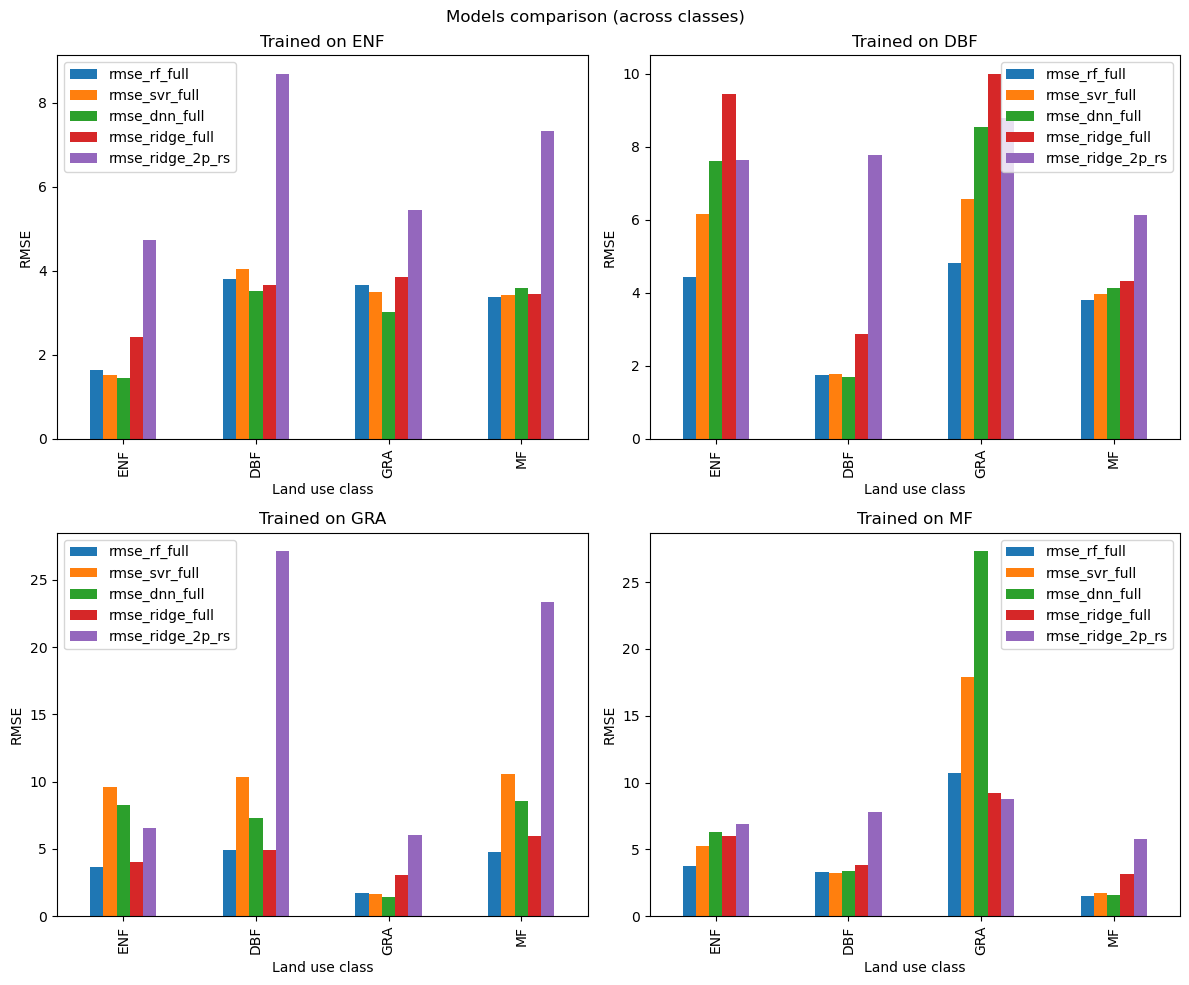

In [13]:
plot_all_scores(
    [
        "rf_full",
        "svr_full",
        "dnn_full",
        "ridge_full",
        "ridge_2p_rs",
        # "knn_2p_rs",
    ]
)

Already present. Skipping.
Already present. Skipping.
Already present. Skipping.
Already present. Skipping.


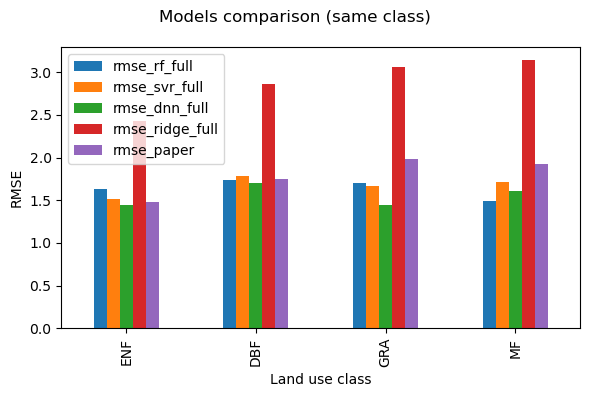

In [15]:
plot_all_scores(
    [
        "rf_full",
        "svr_full",
        "dnn_full",
        "ridge_full",
        # "ridge_2p_rs",
        # "knn_2p_rs",
    ],
    same_only=True,
)

Comments:
- Cannot compare directly paper and my results as they are reporting average scores of LSOCV, while I am more using a LGOCV (or rather I am training on one group only, which is worse).
- Cannot compare as they have encoded the cover type!
- Methodological error: they refit the scaler for each site.
- But all in all, I get the same level of performance when I train  and test on the same group.